This script sends responce to the Claude server with asking to give several points of several curves in the chart. Result is transformed at first to dictionary, then to list of series, then a chart is created to evaluate response.

In [1]:
import anthropic
import base64
import json
import pandas as pd
import ast         # for conversion str to dictionary
import matplotlib.pyplot as plt

In [3]:
# pip install anthropic

In [5]:
# get api_key from file (it is saved in format "api_key: <your_api_key> #comment")
with open('api_key.txt') as fh:
    api_key = fh.readline() \
                     .split(':')[1].split()[0]


client = anthropic.Anthropic(api_key = api_key)

# api_key

In [7]:
# read the image file from disk and encode it to base64 string
def upload_image_from_disk(path_to_image):

    with open(path_to_image, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    return encoded_image


path_to_image = 'input\\Life expectancy in mice.png'
encoded_image = upload_image_from_disk(path_to_image)
# encoded_image[-100:]

<br>
<br>

In [12]:
# The function sends a request to the Claude server and get a response
def prompt_Claude(client,
                  system: str,
                  prompt: str,
                  encoded_image: "base64 string"):

    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1000,
        temperature=0,
        system=system,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": encoded_image
                        }
                    }
                ]
            }
        ]
    )

    return response


# system text and prompt text to send
system = ""
prompt = "This is a chart with several curves. For each curve, identify coordinates on the chart where the curve changes value. " + \
          "Answer must in the form of a Python dictionary. Return only the dictionary, don't round the values."


# send request to Claude server and get response
response = prompt_Claude(client=client, system=system, prompt=prompt, encoded_image=encoded_image)
response_text = response.content[0].text

# convert text-response to dictionary object
dd = ast.literal_eval(response_text)
dd

{'TRE-OSK': [(120, 100),
  (132, 95),
  (136, 85),
  (138, 75),
  (140, 65),
  (142, 55),
  (144, 50),
  (146, 45),
  (148, 40),
  (152, 30),
  (156, 15),
  (160, 10),
  (165, 5)],
 'Control-Dox': [(120, 100),
  (124, 95),
  (126, 90),
  (128, 85),
  (130, 75),
  (132, 65),
  (134, 55),
  (136, 45),
  (138, 40),
  (140, 30),
  (142, 20),
  (144, 10),
  (146, 5)],
 'Jax historical': [(120, 100),
  (126, 95),
  (128, 90),
  (130, 85),
  (132, 75),
  (134, 65),
  (136, 55),
  (138, 50),
  (140, 45),
  (142, 40),
  (144, 35),
  (146, 30),
  (148, 25),
  (150, 20),
  (152, 15),
  (154, 10),
  (158, 5)]}

<br>
<br>

In [19]:
# convert dictionary to list of Series
ls_curves = []
for k,v in dd.items():
    ls_curves.append(pd.Series(data= [tp[0] for tp in v],
                               index=[tp[1] for tp in v],
                               name=k)
                    )

print("Number of series in the list:", len(ls_curves))

# look at the first series in the list
ls_curves[0]

Number of series in the list: 3


100    120
95     132
85     136
75     138
65     140
55     142
50     144
45     146
40     148
30     152
15     156
10     160
5      165
Name: TRE-OSK, dtype: int64

<br>
<br>

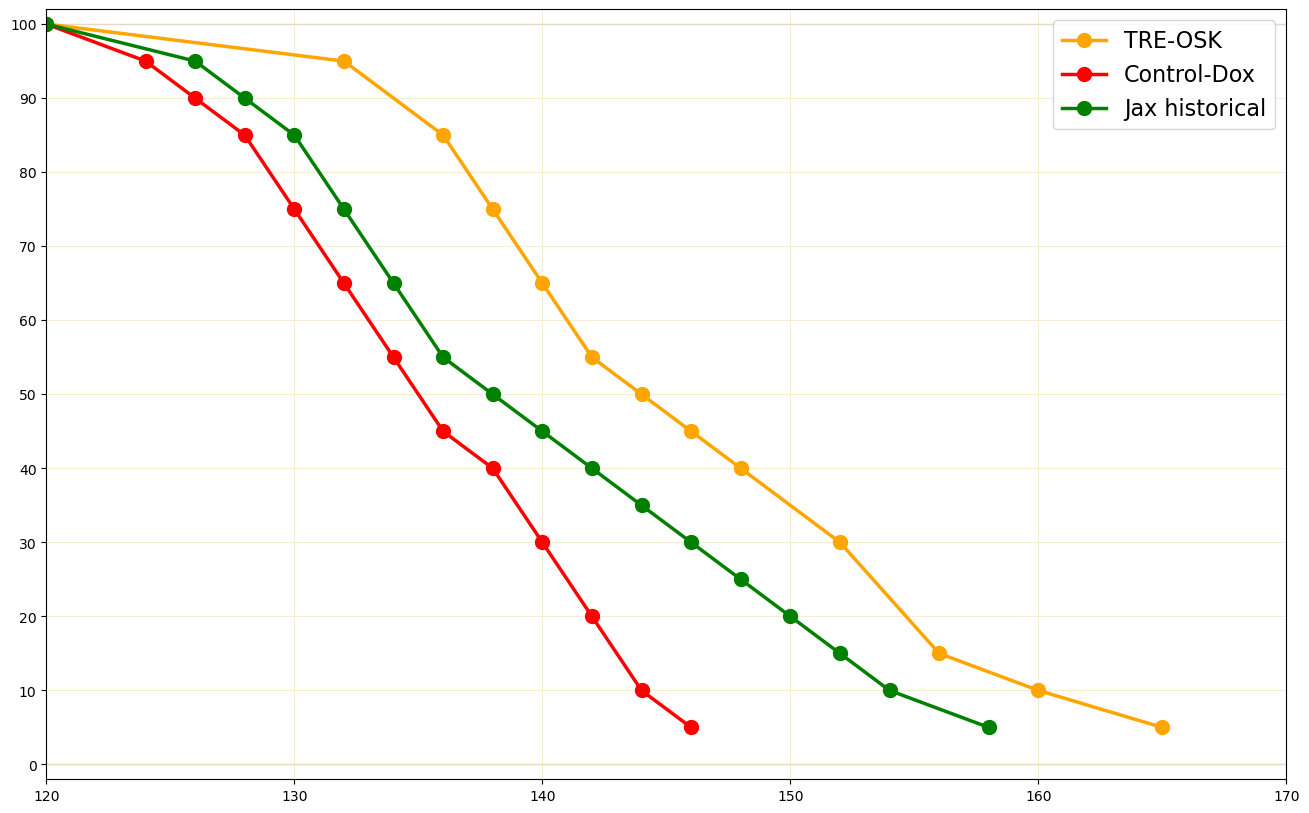

In [21]:
# Create simple cart to visualize result
def create_chart(ls):
    plt.rcParams['figure.figsize'] = (16, 10)

    plt.ylim(-2, 102)
    labels_y = range(0, 101, 10)
    plt.yticks(labels_y)

    plt.xlim(120, 170)
    
    plt.grid(color='wheat', linewidth=0.4)
    plt.axhline(y=0, color='lightgrey', linewidth=1, zorder=0)
    plt.axhline(y=100, color='lightgrey', linewidth=1, zorder=0)

    ls_colors = ['orange', 'red', 'green', 'blue', 'purple', 'indigo']

    for i, ser in enumerate(ls):
        plt.plot(ser.values, ser.index, marker='.', markersize=20,
                 linestyle='-', label=ser.name, linewidth=2.5, alpha=1, color=ls_colors[i])

    plt.legend(loc='upper right', fontsize=16)

    plt.savefig(f"chart analysis//chart from extracted points.png",
            bbox_inches='tight', transparent=True, pad_inches=0.05)  # facecolor='white'
    
    plt.show()


create_chart(ls_curves)

In [51]:
# look at exact values to manually estimate result
print("x0:", ls_curves[0].values)
print("y0:", ls_curves[0].index.to_list())
print()
print("x1:", ls_curves[1].values)
print("y1:", ls_curves[1].index.to_list())
print()
print("x2:", ls_curves[2].values)
print("y2:", ls_curves[2].index.to_list())

x0: [120 132 136 138 140 142 144 146 148 152 156 160 165]
y0: [100, 95, 85, 75, 65, 55, 50, 45, 40, 30, 15, 10, 5]

x1: [120 124 126 128 130 132 134 136 138 140 142 144 146]
y1: [100, 95, 90, 85, 75, 65, 55, 45, 40, 30, 20, 10, 5]

x2: [120 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 158]
y2: [100, 95, 90, 85, 75, 65, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5]
